### Imports

In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
%run silhouette_plotter.py
%run parse.py
from mpl_toolkits.mplot3d import Axes3D

### Load data from Bigquery

In [2]:
table = 'eth-tokens.test.clean_avg_1MM_with_balances_tokens'
label_table = 'eth-tokens.alldata.etherscan_labelcloud'

In [3]:
sql = '''
SELECT *  FROM `{}`
'''.format(table)

df = client.query(sql).to_dataframe()

In [4]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [5]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4
num_features = 15

In [6]:
log = FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=True)
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)

#build pipeline
pipe = Pipeline([('log', log ),
                 ('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)




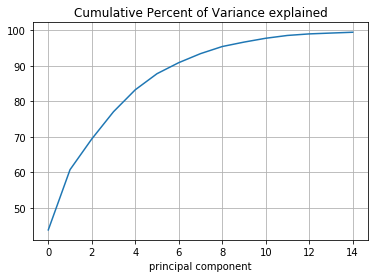

In [7]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

### Choose number of clusters with Calinski-Harabaz, Elbow Plot

In [8]:
# #scoring metric?
# from sklearn.metrics import calinski_harabaz_score as ch_score
# clusters = [3,5,8,10,15,20,30,40,60,80]
# scores = []
# inertias = []
# for c in clusters:
#     cl_n = KMeans(c).fit(results)
#     score = ch_score(results, cl_n.labels_)
#     scores.append(score)
#     inertias.append(cl_n.inertia_)


# plt.plot(clusters, scores)
# plt.title('Calinski Harabaz Scores')

In [9]:
# #elbow plot
# plt.plot(clusters,inertias)
# plt.title('Elbow plot')
# plt.ylabel('within cluster sum of squares')

## Optimal clusters

In [10]:
#optimal number of clusters is around 40
cl = KMeans(15)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [11]:
# %run silhouette_plotter.py
# X=results
# range_n_clusters = [20]
# if len(newresults) <20000:
#     silhouette_plotter(X, range_n_clusters)

In [12]:
#subset results for tsne
#address mask needed for later superposition
max_size = 25000#len(results)
subset_results = []
lbls = []
address_mask = np.array([False for addr in df['address']]) 
for c in np.unique(cl.labels_):
    mask = (cl.labels_==c)
    c_size = np.sum(mask)
    if c_size < max_size:
        lbls.extend(list(cl.labels_[cl.labels_==c]))
        subset_results.append(results[mask])
        address_mask |= mask
lbls=np.array(lbls)
subset_results=np.vstack(subset_results)

In [13]:
#not using subset
subset_results = results
lbls = cl.labels_

In [14]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=800)
tsne_results = tsne.fit_transform(subset_results)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 239630 samples in 0.252s...
[t-SNE] Computed neighbors for 239630 samples in 194.693s...
[t-SNE] Computed conditional probabilities for sample 1000 / 239630
[t-SNE] Computed conditional probabilities for sample 2000 / 239630
[t-SNE] Computed conditional probabilities for sample 3000 / 239630
[t-SNE] Computed conditional probabilities for sample 4000 / 239630
[t-SNE] Computed conditional probabilities for sample 5000 / 239630
[t-SNE] Computed conditional probabilities for sample 6000 / 239630
[t-SNE] Computed conditional probabilities for sample 7000 / 239630
[t-SNE] Computed conditional probabilities for sample 8000 / 239630
[t-SNE] Computed conditional probabilities for sample 9000 / 239630
[t-SNE] Computed conditional probabilities for sample 10000 / 239630
[t-SNE] Computed conditional probabilities for sample 11000 / 239630
[t-SNE] Computed conditional probabilities for sample 12000 / 239630
[t-SNE] Computed conditional prob

In [40]:
#setting up color map
NUM_COLORS = len(dflabel['category'].unique())
cm = plt.get_cmap('tab20')

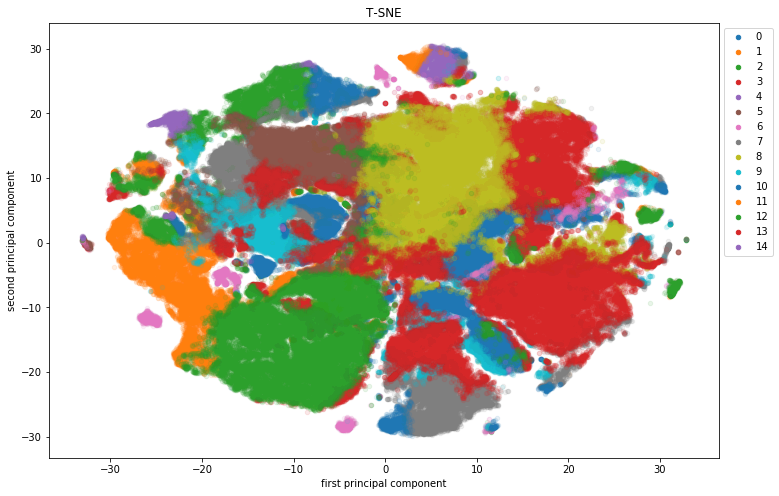

In [17]:
#color coded by cluster
fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(111)
# ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


for c in np.unique(cl.labels_):
    mask = cl.labels_==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], s=20, alpha=.1,label=lbl)
    
leg = plt.legend(bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)




plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

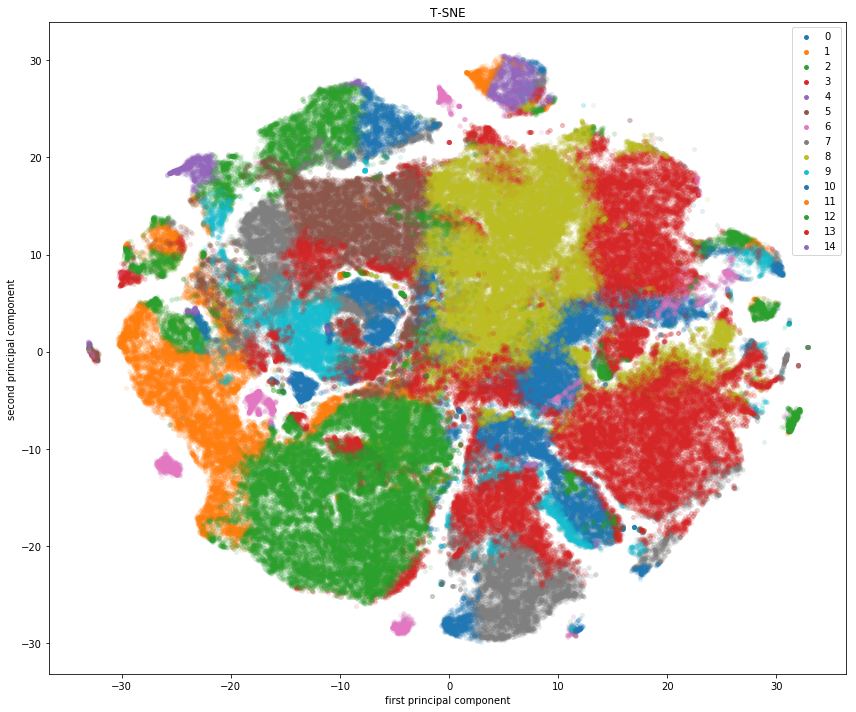

In [18]:

plt.figure(figsize=(12,10))
for c in np.unique(lbls):
    mask = lbls==c
    if np.sum(mask) <0:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], s=15,alpha=.1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.tight_layout()

In [ ]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-15,10)

## Label centroids with cluster

In [19]:
c = cl.cluster_centers_
#transform back to real numbers
centroids = log.inverse_transform(scale.inverse_transform(pca.inverse_transform(c)))
df_summary = pd.DataFrame(centroids, columns = data.columns)

In [20]:
#put cluster sizes into summary dataframe
cluster_sizes = pd.Series(cl.labels_).value_counts()
df_summary['cluster_size'] = cluster_sizes


In [21]:
df_summary.sort_values('cluster_size', ascending=False, axis=0, inplace=True)
df_summary

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster_size
8,6.392438,8.370719,7.285920,1.355983,3.537404e+03,565.818389,13.516049,2.078155,6.066391e+03,737.226901,...,422.945630,0.002363,0.005091,2.408511e+06,3.134386e+06,2.787751e+06,3.239382e+06,9.895347,4.302349,38067
12,7.693936,62.163327,4.995379,0.678192,2.040182e+03,272.618728,10.933126,0.092154,3.991438e+03,66.166818,...,316.359023,0.001690,0.002923,3.403662e+05,1.931968e+05,1.790697e+06,1.797532e+06,5.237275,3.668452,33221
13,7.078075,8.700158,33.729488,5.415122,1.944884e+04,2745.962358,62.243520,8.298406,2.705308e+04,3165.343100,...,1874.405997,0.001611,0.002757,1.953240e+06,2.676561e+06,2.100361e+06,2.624628e+06,10.543067,13.006354,30756
0,5.865182,7.436998,6.413023,1.327113,3.536868e+03,621.563586,10.889621,1.916794,6.313740e+03,865.627147,...,694.161669,0.000960,0.001814,8.037117e+05,9.165440e+05,5.499299e+05,5.750790e+05,4.425257,3.668860,24196
3,5.428138,9.029671,1.522994,0.328036,3.284041e+02,67.572840,4.551635,0.575540,1.517931e+03,173.859386,...,123.699708,0.004973,0.010911,1.688484e+06,1.826090e+06,1.553800e+06,1.650771e+06,6.165794,2.317779,23446
1,16.276679,225.481545,37.269064,2.847659,1.961407e+04,1217.482449,59.768206,0.431141,2.687565e+04,116.330279,...,1961.885969,0.003351,0.005209,1.235617e+05,9.951651e+04,1.214420e+06,1.467589e+06,7.977754,10.163907,18629
5,28.187627,25.110210,41.012789,1.876302,2.438539e+04,896.443309,53.142123,2.647319,3.009438e+04,1240.281426,...,2134.879945,0.000575,0.000104,8.952355e+05,1.377221e+06,6.638027e+05,1.300281e+06,19.938893,5.024784,18382
7,10.890085,12.245644,306.790137,26.785579,1.312953e+05,12254.922546,483.250593,35.432843,1.390034e+05,11747.505513,...,8939.893393,0.003974,0.008914,1.432450e+06,2.222568e+06,1.628983e+06,2.518802e+06,14.078491,42.795761,18211
9,9.613222,12.292079,67.505173,9.036646,2.736587e+04,3013.332792,87.850533,9.506002,3.919785e+04,3338.193768,...,6356.586010,0.000751,0.000788,3.500324e+05,4.707959e+05,5.203172e+05,6.731133e+05,3.079924,9.919736,10274
2,77.013401,114.581673,769.949616,12.794633,3.487576e+05,4596.855788,769.563336,8.960282,3.943299e+05,3415.816835,...,31649.084727,0.002360,0.005680,2.103700e+05,4.468382e+05,3.057230e+05,6.028769e+05,18.462083,13.656933,9205


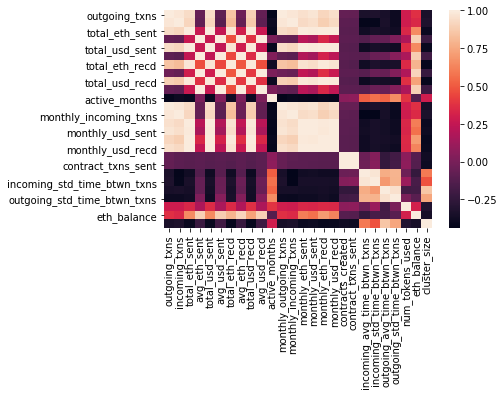

In [22]:
import seaborn as sns
sns.heatmap(df_summary.corr())

In [23]:
arr = df_summary.values

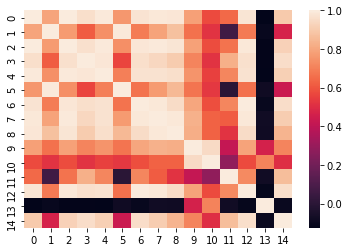

In [24]:
sns.heatmap(np.corrcoef(arr, rowvar=True))

## Review Etherscan Labels

In [25]:
sql = '''
SELECT es.label,es.category, a.*  FROM `{}` a
INNER JOIN `{}` es
ON a.address = es.address
WHERE es.label IS NOT NULL

'''.format(table, label_table)

dflabel = client.query(sql).to_dataframe()

In [26]:
lbls = []
for i, row in dflabel.iterrows():
    lbls.append(list(df['address'].values).index(row['address']))

In [27]:
dflabel['cluster'] = [cl.labels_[i] for i in lbls]

In [28]:
for clust in range(cl.n_clusters):
    print('cluster {}'.format(clust))
    print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
    print('total points: {}'.format(np.sum(cl.labels_==clust)))
    print(dflabel[dflabel['cluster']==clust][['label','category']])
    print('\n\n\n')

cluster 0
labelled points: 9
total points: 24196
                label    category
2   Fake_Phishing2168  Phish/Hack
3   Fake_Phishing2172  Phish/Hack
4   Fake_Phishing1822  Phish/Hack
5   Fake_Phishing1816  Phish/Hack
12  Fake_Phishing1817  Phish/Hack
17  Fake_Phishing1789  Phish/Hack
28  Fake_Phishing1133  Phish/Hack
32  Fake_Phishing2284  Phish/Hack
38  Fake_Phishing1319  Phish/Hack




cluster 1
labelled points: 5
total points: 18629
                    label    category
21      Fake_Phishing1746  Phish/Hack
45       Fake_Phishing631  Phish/Hack
53       Fake_Phishing638  Phish/Hack
54       Fake_Phishing429  Phish/Hack
66  EuropeanCryptoBankICO  Token Sale




cluster 2
labelled points: 6
total points: 9205
                    label    category
11               Bitmax_2    Exchange
18      Fake_Phishing1624  Phish/Hack
49   MyEtherWallet_Donate      Donate
57             KuveraPool      Mining
74       Fake_Phishing710  Phish/Hack
115              Huobi_11    Exchange




cluster 

centralization of ownership

In [29]:
total_eth = {}
total_addresses = {}

for clust in range(cl.n_clusters):
    mask = cl.labels_==clust
    eth = np.sum(df[mask]['eth_balance'])
    size = np.sum(cl.labels_==clust)
    total_eth[clust] = eth
    total_addresses[clust] = size

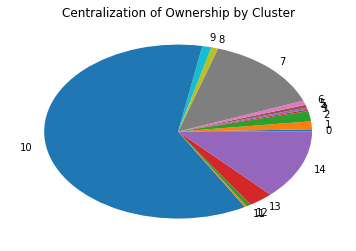

In [30]:
plt.pie(total_eth.values(), labels=total_eth.keys())
plt.title('Centralization of Ownership by Cluster')
plt.show()

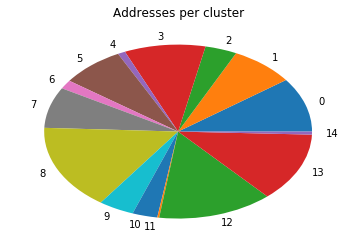

In [31]:
plt.pie(total_addresses.values(), labels=total_addresses.keys())
plt.title('Addresses per cluster')
plt.show()

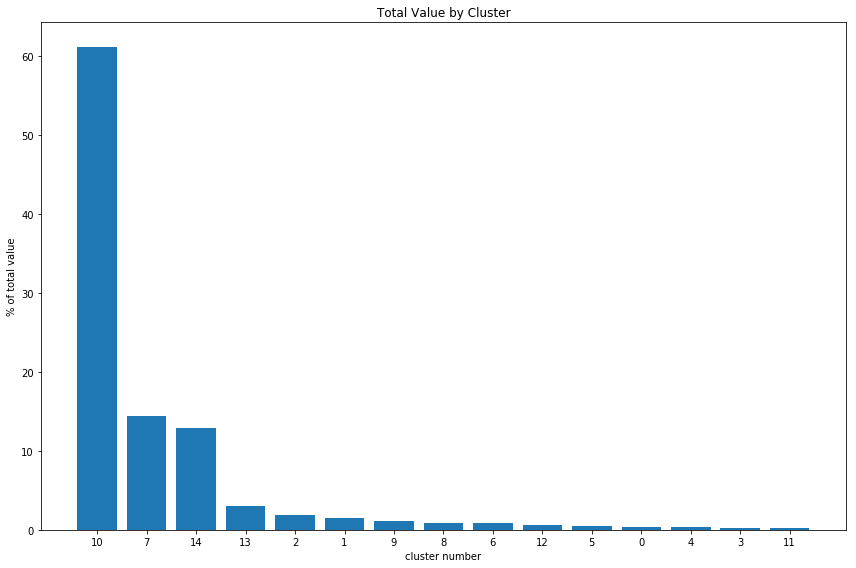

In [32]:

names = np.array(list(total_eth.keys()))
values = np.array(list(total_eth.values()))
indices = np.argsort(values)

names = names[indices][::-1]
values = values[indices][::-1]
                  
#tick_label does the some work as plt.xticks()
plt.figure(figsize=(12,8))
plt.bar(range(len(total_eth)),values/sum(values)*100,tick_label=names)
plt.title('Total Value by Cluster')
plt.xlabel('cluster number')
plt.ylabel('% of total value')
# plt.yscale('log')
plt.tight_layout()
plt.show()




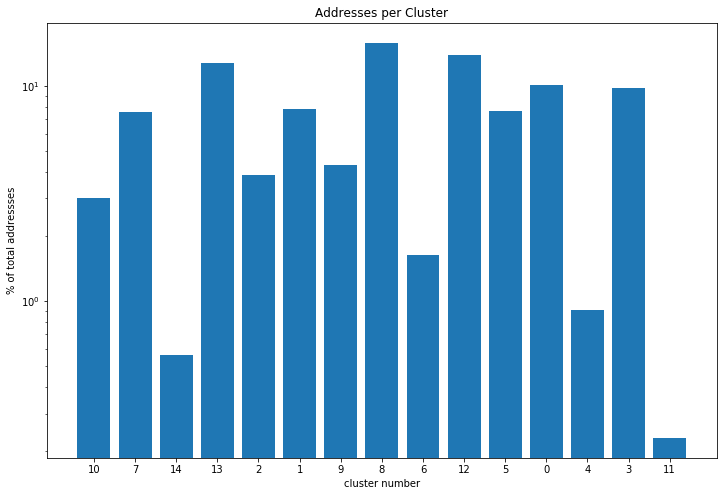

In [33]:

names = np.array(list(total_addresses.keys()))
values = np.array(list(total_addresses.values()))

names = names[indices][::-1]
values = values[indices][::-1]
                  
#tick_label does the some work as plt.xticks()
plt.figure(figsize=(12,8))
plt.bar(range(len(total_addresses)),values/sum(values)*100,tick_label=names)
plt.title('Addresses per Cluster')
plt.yscale('log')
plt.xlabel('cluster number')
plt.ylabel('% of total addressses')
plt.show()

In [34]:


# for clust in range(cl.n_clusters):
#     cluster_data = df[cl.labels_==clust]
#     print('cluster {}'.format(clust))
#     logbins = np.logspace(0,8,16)
#     plt.hist(cluster_data['incoming_avg_time_btwn_txns'], bins=logbins)
#     plt.xscale('log')
#     plt.show()
    

In [35]:
labelresults = pipe.fit_transform(dflabel.iloc[:,3:-1])

In [36]:
labelcl = KMeans(15).fit(labelresults)
dflabel['cluster'] = [labelcl.labels_[i] for i in range(len(dflabel))]

In [37]:
time_start = time.time()
tsne_label = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=20000)
tsne_results_label = tsne_label.fit_transform(labelresults)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 182 samples in 0.000s...
[t-SNE] Computed neighbors for 182 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 182 / 182
[t-SNE] Mean sigma: 1.924563
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.895741
[t-SNE] KL divergence after 1000 iterations: 0.314548
t-SNE done! Time elapsed: 0.5921318531036377 seconds


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


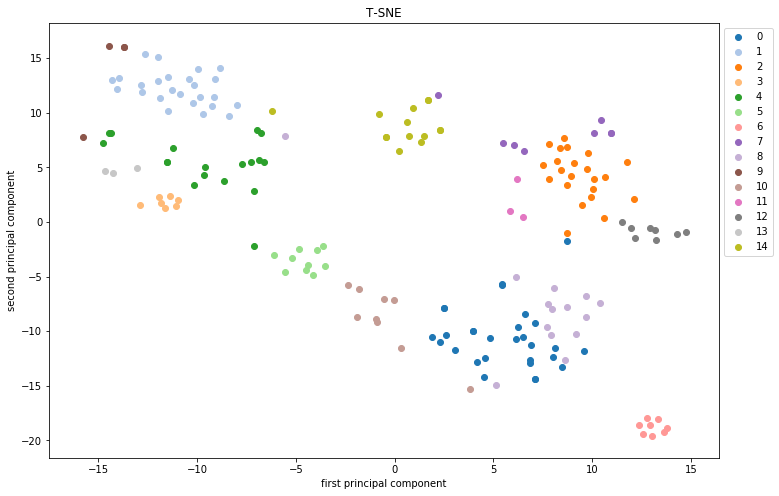

In [41]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for c in np.unique(labelcl.labels_):
    mask = labelcl.labels_==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results_label[mask][:,0], tsne_results_label[mask][:,1], alpha=1,label=lbl)
leg = plt.legend(bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


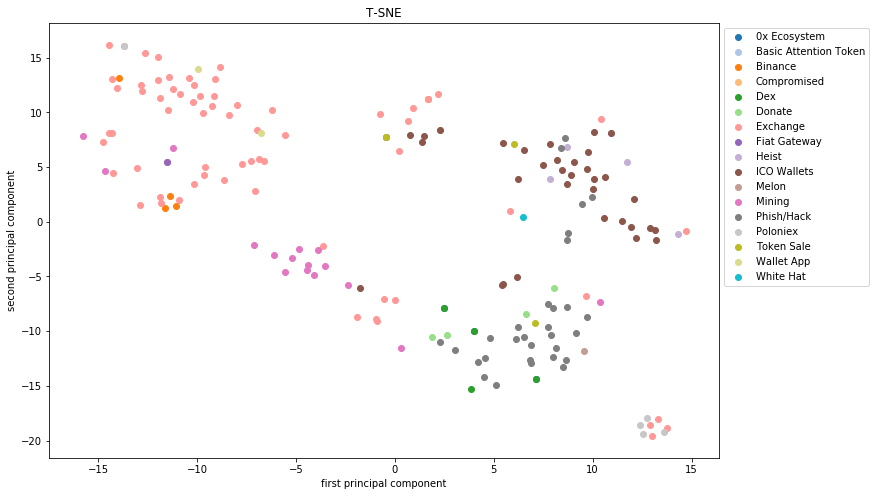

In [42]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for c in np.unique(dflabel['category']):
    mask = dflabel['category']==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results_label[mask][:,0], tsne_results_label[mask][:,1], alpha=1,label=lbl)
leg = plt.legend(bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

## subset original T-SNE results
create a mask for all points that are labelled

In [43]:
labeled_addresses = dflabel['address'].values
labelmask = np.array([addr in labeled_addresses for addr in df['address'] ] )

# #labelmask for subset results!!!
# labelmask = np.array([addr in labeled_addresses for addr in df['address'][address_mask]] )

In [44]:
#helper function for category mask
def cat(addr, labeled_addresses, dflabel):
    if addr not in labeled_addresses:
        return False
    else:
        idx = int(np.where(labeled_addresses==addr)[0][0])
        return dflabel['category'][idx]

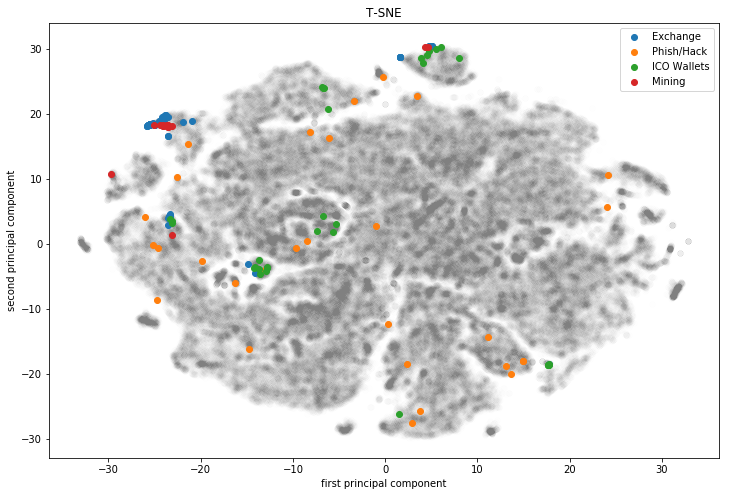

In [46]:
subset, not_subset  = tsne_results[labelmask] , tsne_results[~labelmask]
fig = plt.figure(figsize=(12,8))
#not labelled points
plt.scatter(not_subset[:,0], not_subset[:,1], c='gray', alpha=.005)

#categories
cats = np.array([cat(addr, labeled_addresses, dflabel) for addr in df['address']])#[address_mask] ]) #added address mask for all clusters

# # #labelled points

# ax = fig.add_subplot(111)
# ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for c in list(dflabel['category'].unique()):
    mask = dflabel['category']==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    
    #category mask
    catmask = cats == c
    if np.sum(mask) >5:
        plt.scatter(tsne_results[(labelmask & catmask)][:,0], tsne_results[(labelmask & catmask)][:,1], alpha=1,label=lbl)

leg = plt.legend(bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

In [ ]:
# for clust in range(cl.n_clusters):
#     print('cluster {}'.format(clust))
#     print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
#     print('total points: {}'.format(np.sum(cl.labels_==clust)))
#     print(dflabel[dflabel['cluster']==clust][['label', 'category']])
#     print('\n\n\n')